# Multi-armed bandits and types of action selection

In the previous notebooks, we have seen that value learning takes variants of the form:

$$NewEstimate \leftarrow OldEstimate + StepSize \cdot (Target-OldEstimate) $$

This notebook will use a more modern RL application, the **multi-armed bandit environment**, and investigate different ways of **action selection**. A particular focus is on the trade-off between **exploitation** and **exploration**.

The structure of the code is inspired by Sutton and Barto, Chapter 2: Multi-armed Bandits as well as the multi-armed bandits tutorial from Neuromatch 2020 (https://academy.neuromatch.io/nma2020/course-materials).

We start with the usual imports and defining some helper functions.

In [10]:
# Imports
import numpy as np                 
import matplotlib.pyplot as plt

In [11]:
# @title Helper functions to plot

# simulate action selections
def plot_choices(v, choice_fn, n_steps=1000, rng_seed=1, verbose=False):
  
  np.random.seed(rng_seed)
  counts = np.zeros_like(v)

  for t in range(n_steps):
    action = choice_fn(v)
    counts[action] += 1

  # now make plots:
  plt.rcParams['figure.figsize'] = [10, 3]
  rows = 1
  cols = 2
  fig = plt.figure() 
  fig_count = 1

  fig.add_subplot(rows, cols, fig_count)
  plt.bar(np.arange(len(v)), v)
  plt.plot(np.arange(-1,len(v)+1),np.zeros(len(v)+2),'--k')
  plt.ylabel('Value')
  plt.xlabel('Action')
  plt.title('Input Value')
  plt.xticks(np.arange(len(v)))
  fig_count += 1

  fig.add_subplot(rows, cols, fig_count)
  plt.bar(np.arange(len(v)), counts/n_steps)
  plt.ylabel('% chosen')
  plt.xlabel('Action')
  plt.title('Chosen action')
  plt.ylim([0,1.2])
  plt.xticks(np.arange(len(v)))

  plt.show()

  if verbose:
    print("Values: " + str(v))
    print("Relative counts: " + str(counts/n_steps))

# plot performance
def plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal):

  plt.rcParams['figure.figsize'] = [15, 5]
  rows = 1
  cols = 2
  fig = plt.figure() 
  fig_count = 1;

  fig.add_subplot(rows, cols, fig_count)
  plt.plot(np.mean(trial_rewards, axis=1).T)
  plt.ylabel('Reward')
  plt.xlabel('Step')
  if len(fixed)>0:
    plt.title(f'Average Reward ({fixed})')
  else:
    plt.title('Average Reward')
  plt.legend(labels)
  fig_count += 1

  fig.add_subplot(rows, cols, fig_count)
  plt.plot(np.mean(trial_optimal, axis=1).T)
  plt.ylabel('% optimal')
  plt.xlabel('Step')
  if len(fixed)>0:
    plt.title(f'Performance ({fixed})')
  else:
    plt.title('Performance')
  plt.legend(labels)

  # btw, a more readable but perhaps less beginner-friendly plotting version is this:
  # fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
  # ax1.plot(np.mean(trial_rewards, axis=1).T)
  # ax1.set(title=f'Average Reward ({fixed})', xlabel='step', ylabel='reward')
  # ax1.legend(labels)
  # ax2.plot(np.mean(trial_optimal, axis=1).T)
  # ax2.set(title=f'Performance ({fixed})', xlabel='step', ylabel='% optimal')
  # ax2.legend(labels)

---
# Part 1: Types of Action Selection

In RL, action selection is governed via **policies**. A policy specifies the probability of selecting a certain action in a certain state:

$$\pi(a,s)=P(a_t=a|s_t=s)$$

We can omit the state representation for now - but this will come back when we look into model-based RL.

## Greedy Action Selection

The simplest policy is to simply always choose the most valuable action. This policy is called **greedy**, and can be defined as:

\begin{align}
P (a_t = a) = 
        \begin{cases}
        1    & \quad \text{if } a_{t} = \text{argmax}_{a} \; V_t (a) \\
        0        & \quad \text{otherwise} 
        \end{cases} 
\end{align}

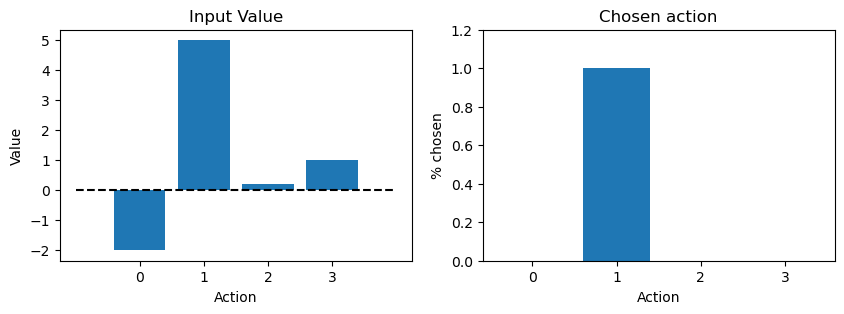

In [12]:
def greedy(v):
  """Greedy policy: always select the maximum value action.
    
  Input:
    v: an array of action values
  
  Returns:
    action: the chosen action
  """
  action = np.argmax(v)

  return action

# Simulate data selection with some values in a 4-arm bandit:
v = [-2, 5, 0.2, 1]

plot_choices(v, greedy)

What values do the chosen actions converge on?

## Epsilon-Greedy Action Selection

We have also seen that epsilon-greedy provides a simple alternative that enables some form of random exploration via

\begin{align}
P (a_t = a) = 
        \begin{cases}
        1-\epsilon    & \quad \text{if } a_{t} = \text{argmax}_{a} \; V_t (a) \\
        \epsilon/N        & \quad \text{otherwise} 
        \end{cases} 
\end{align}

For an $\epsilon \in [0,1]$. 

We have also seen how we can implement this:

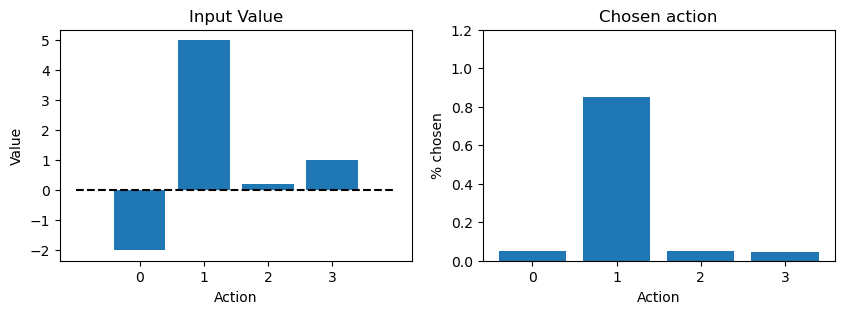

In [13]:
def epsilon_greedy(v,epsilon=0.2):
  """Epsilon-greedy policy: always select the maximum value action, except be random sometimes
    
  Input:
    v: an array of action values
    epsilon: probability of selecting an action randomly
  
  Returns:
    int: the chosen action
  """
  rand_num = np.random.rand(1)

  if rand_num > epsilon:
    action = np.argmax(v)
  else:
    action = np.random.choice(len(v))

  return action

# Simulate data selection with some values in a 4-arm bandit:
v = [-2, 5, 0.2, 1]

plot_choices(v, epsilon_greedy)

What values do the chosen actions converge on?

## Softmax Action Selection

Epsilon-greedy provides a very simple form of random exploration in action selection. However, often we want the degree of randomness to make use of the actual values in our choice problem. 

One way of achieving this is by passing the values for each action through a **softmax distribution** (also: Gibbs or Boltzmann distribution):

$$P (a_t = a) = \frac{e^{V_t (a) \cdot \beta}}{\sum_{i=1}^N e^{V_t (a_i) \cdot \beta}}$$

This looks complicated but actually it's not. It just means we are normalising the value of a current action by a particular way of summarising all values. This normalisation depends on:
* The exponential function $e$ (hint: there is a 'np.' command for that, just as for almost everything else..)
* The current value of an action at a given time $V_t (a)$
* The value of all other actions $i \in [1,N]$ actions
* A parameter $\beta$. This parameter is called **inverse temperature**, and is really important: it governs how sensitive agents are to value differences between the actions. (Hint: use np.multiply to spcify the pointwise multiplication of the values with $\beta$)



In [14]:
# @title Exercise 1.1: Implement softmax action selection

Can you define a function called 'softmax_rule' that defines softmax action selection?

In [15]:
# Your code goes here..

In [16]:
# @title Partial Solution

def softmax_rule(v,beta=0.2):
  """Softmax policy: always select the maximum value action.
    
  Input:
    v: an array of action values
    beta: inverse temperature that governs an agent's sensitivity to value differences
  
  Returns:
    int: the chosen action
  """
  # define action probabilities according to the equation above
  # action_prob = ...

  # sample one action according to the specified probabilities
  # action = ...

  return action.astype(int)

# Simulate data selection with some values in a 4-arm bandit:
# v = [-2, 5, 0.2, 1]
# plot_choices(v, softmax_rule)

Output should look like this


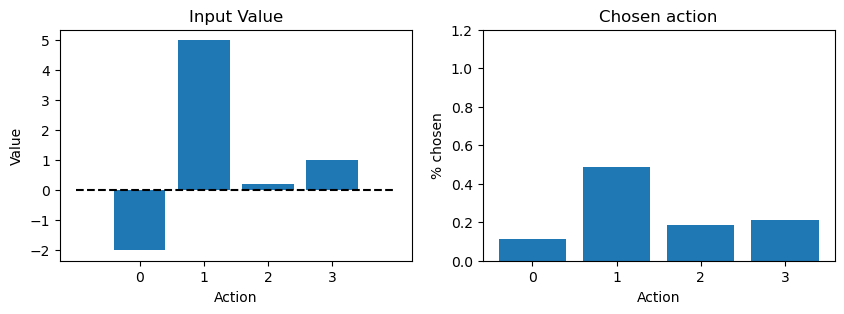

In [17]:
# title Full Solution

print("Output should look like this")

def softmax_rule(v,beta=0.2):
  """Softmax policy: always select the maximum value action.
    
  Input:
    v: an array of action values
    beta: inverse temperature that governs an agent's sensitivity to value differences
  
  Returns:
    int: the chosen action
  """
  action_prob = (np.exp(np.multiply(v,beta))) / np.sum(np.exp(np.multiply(v,beta)))

  action = np.random.choice(np.arange(len(v)), 1, True, action_prob)

  return action.astype(int)

# Simulate data selection with some values in a 4-arm bandit:
v = [-2, 5, 0.2, 1]

plot_choices(v, softmax_rule)

What values do the chosen actions reflect - how are they determined, what do they depend on?

In [18]:
# @title Exercise 1.2: Implement softmax action selection with different betas

Change the value of beta and see what happens - can you tell what beta determines?

## Upper-Confidence-Bound Action Selection

The above examples implement **random exploration**. However, we sometimes want exploration to be **goal-directed**, and select the option that we are most uncertain about. 

This can get complicated easily, but a simple way of achieving that is via **upper-confidence-bound action selection**. The basic idea here is to explore actions based on how often they were chosen before, normalised by how often you have chosen an action in general already:

$$P (a_t = a) = \text{argmax}_{a} [V_t (a)+c \cdot \sqrt{\frac{\ln t}{N_t(a)}}]$$

Where:

* $V_t (a)$ is the current value of an action at a given time 
* ln is the natural logarithm of a given time-point t
* $N_t(a)$ is the number of times action $a$ has been selected before
* $c$ is an individual parameter that governs how sensitive an agent is to sampling novel actions

In [19]:
# @title Exercise 1.3: Implement Upper-confidence-bound action selection

Can you implement upper-confidence-bound action selection in a function called upp_conf_bound? 

This will require the definition of some current time-step and number of times actions have been visited before. You can just simulate this for some interesting values for now (with $t>1$). 

For example, imagine a case where all actions have the same value, but they have been sampled differently often.

In [20]:
# Your code goes here..

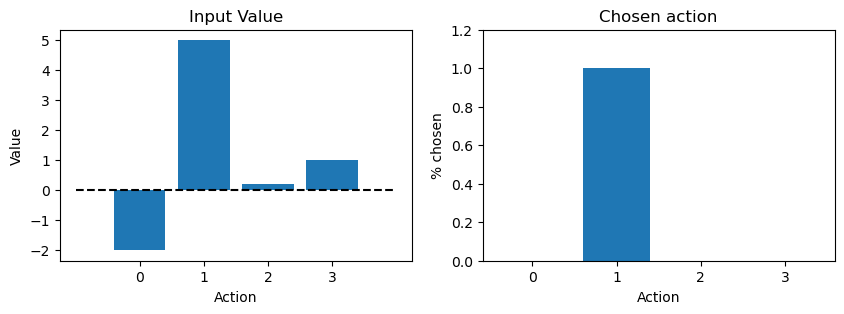

In [21]:
# @title Partial Solution

def upp_conf_bound(v,c=5,t=1,N=[]):
  """Greedy policy: always select the maximum value action.
    
  Input:
    v: an array of action values
  
  Returns:
    int: the chosen action
  """
  if len(N)==0:
    N = np.linspace(100,1,len(v))

  # define the action selection rule as defined above
  action = np.argmax(v + np.multiply(c, np.sqrt(np.log(t)/N)))

  return action

# Simulate data selection with some values in a 4-arm bandit:
v = [-2, 5, 0.2, 1]
# v = [1, 1, 1, 1]
plot_choices(v, upp_conf_bound)

Output should look like this


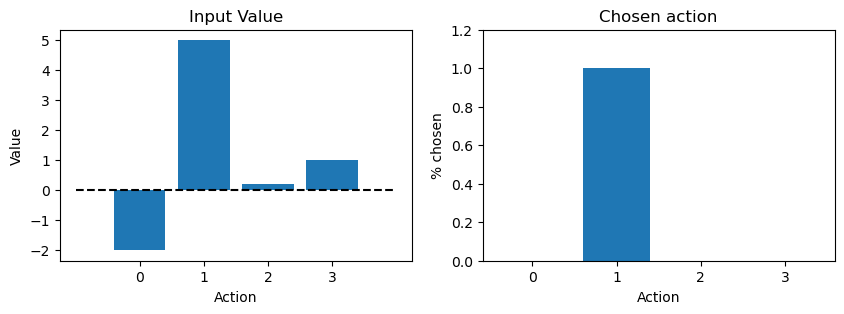

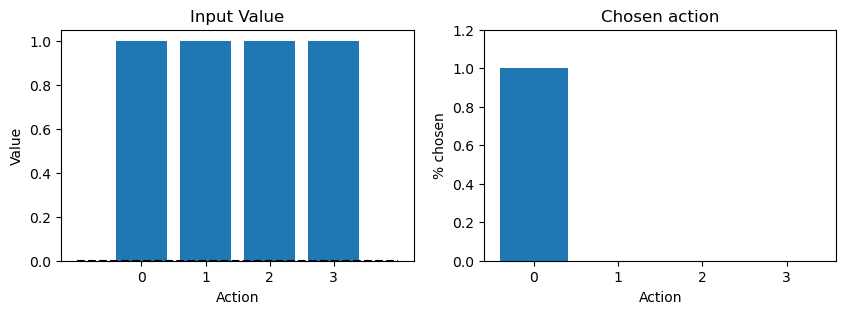

In [22]:
# title Full Solution

print("Output should look like this")

def upp_conf_bound(v,c=5,t=1,N=[]):
  """Greedy policy: always select the maximum value action.
    
  Input:
    v: an array of action values
  
  Returns:
    int: the chosen action
  """
  if len(N)==0:
    N = np.linspace(100,1,len(v))

  action = np.argmax(v + 
                     np.multiply(c,
                                 np.sqrt(np.divide(np.log(t),
                                                   N))))

  return action

# Simulate data selection with some values in a 4-arm bandit:
v = [-2, 5, 0.2, 1]
plot_choices(v, upp_conf_bound)

v = [1, 1, 1, 1]
plot_choices(v, upp_conf_bound)

In [23]:
# @title Exercise 1.4: Parameters in upper-confidence-bound

UCB depends on a lot of parameters (t,c,N). Can you simulate action selection under different parameter settings? Which parameter governs what?

In [24]:
# @title Exercise 1.5: Recap parameters

You have seen a lot of different parameters already, moving wildly through the Greek alphabet.

Which ones do you remember, and what specifically do they influence?

---
# Part 2: Compare performances

Now, let's move to a **multi-armed bandit problem** and see how the different policies/rules of action selections above perform. We'll be in a context where agents have to choose between several actions (default is set to n_arms = 10, but feel free to change that).

The multi-armed bandit is a classic testbed to study the issue of **exploration vs. exploitation**, and a central environment for RL research. Initially, the agent has no idea which arm is good or bad. Gradually, it will learn about good and bad choices via trial-end-error - but how this learning unfolds is very different under the algorithmic rules above.

Since we are dealing with very simple choice-outcome associations, we can use a **simple one-step learning rule** (so no need for TD learning or backpropagating knowledge in time). We will come back to this wenn we discuss **Q-learning**.

The following is meant to guide you through the process of analysing performance differences between different agent architectures. This is an essential part of behavioural RL research, with the aim of testing how well different architectures account for real-life behaviour.

In [25]:
# @title Exercise 2.0: Predict behaviour

What type of behaviour do you think the greedy, epsilon-greedy, softmax and UCB action selection rules predict for our multi-arm bandit problem? Which one will be particularly good or bad, and when (e.g. early or late in the experiment)?

## Define updates of action value

We'll start with defining a function that we can use to simulate value learning. For the examples used here, these will be a simple one-step learning rule.

In [26]:
def update_action_value(v, action, reward, alpha):
  
  """ Compute the updated action value given the learning rate and observed
  reward.

  Input:
    v: array of action values
    action: the action taken
    reward: the reward received for taking the action
    alpha: the learning rate
  
  Returns:
    value: the updated value for the selected action
  """
  value = v[action] + alpha * (reward - v[action])

  return value

## Define Multi-Armed Bandit Environment

Now define multi-armed bandit environment. 

This is fairly dense code. Can you figure out what's going on below?

In [27]:
def multi_armed_bandit(n_arms, n_steps, epsilon=0.1, alpha=0.01):

  """ 
  A Gaussian multi-armed bandit environment. For each
  action, rewards are randomly sampled from normal distribution, with a mean
  associated with that specific arm.
  
  Input:
    n_arms: number of arms or actions
    epsilon: probability of selecting an action randomly
    alpha: the learning rate
    n_steps: number of steps to evaluate
  
  Returns:
    results: a dictionary containing the action values, actions, and rewards from
    the evaluation along with the true arm parameters mu and the optimality of
    the chosen actions (i.e. was the action of a trial the best one?)
  """
  # Gaussian bandit parameters - means for every arm
  mu = np.random.normal(scale=2,size=n_arms)

  # evaluation and value of state
  v  = np.zeros(n_arms)
  vs = np.zeros((n_steps, n_arms))

  rewards = np.zeros(n_steps)
  actions = np.zeros(n_steps)
  optimal = np.zeros(n_steps)

  # run the bandit
  for t in range(n_steps):
    # choose an action
    action = epsilon_greedy(v,epsilon)
    actions[t] = action
    
    # compute rewards for all actions - this is induces some trial-by-trial noise
    all_rewards = np.random.normal(mu)

    # observe the reward for the chosen action
    reward     = all_rewards[action]    
    rewards[t] = reward

    # was it the best possible choice?
    optimal_action = np.argmax(all_rewards) # find optimal action of that given trial
    optimal[t]     = action == optimal_action # see if chosen action was the optimal action of that trial

    # update the action value
    v[action] = update_action_value(v, action, reward, alpha)
    vs[t]     = v

  # the below is called a dictionary, which is handy when storing many variables
  results = {
      'vs': vs,
      'actions': actions,
      'rewards': rewards,
      'mu': mu,
      'optimal': optimal
  }
  
  return results

## Test performance of an agent

Now let's simulate the above agent and assess it's performance:

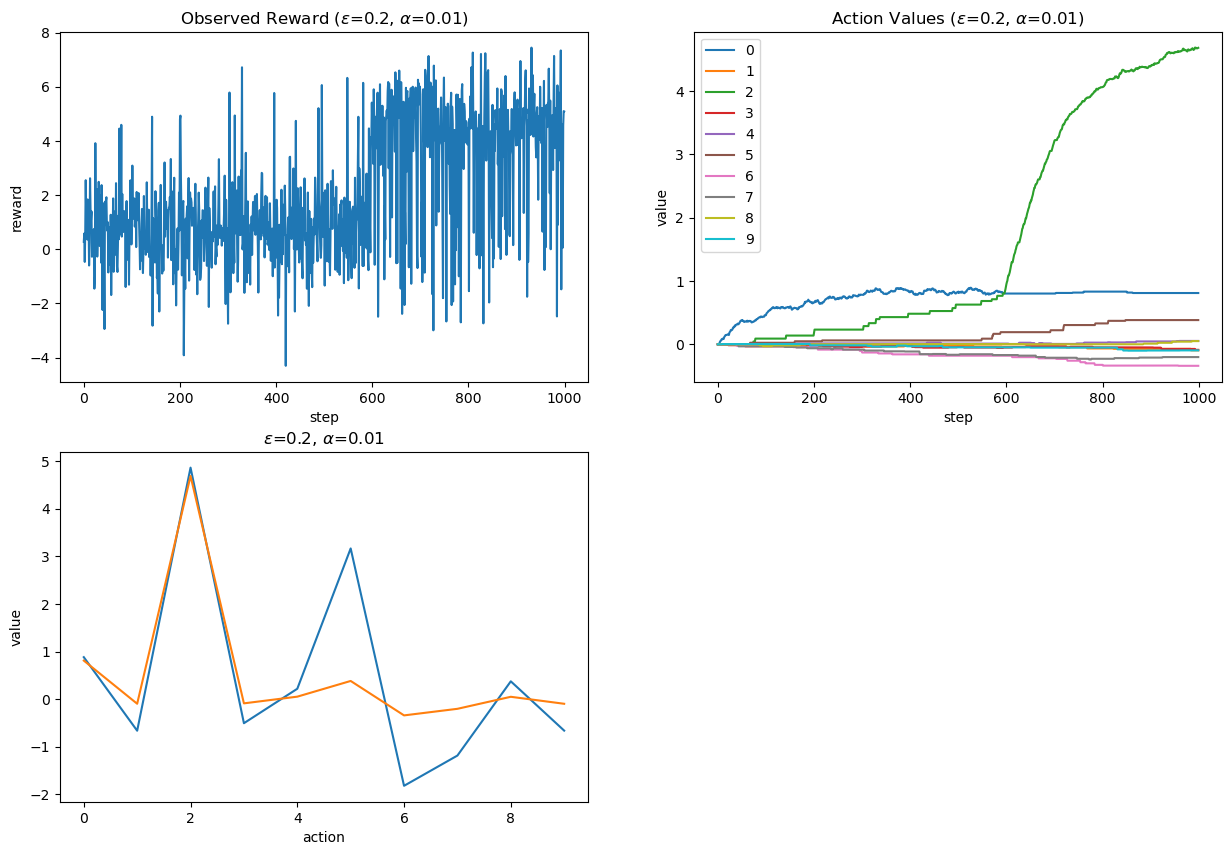

In [49]:
# set for reproducibility, change seed value for different results
np.random.seed(5)

n_arms  = 10
n_steps = 1000
epsilon = 0.2
alpha   = 0.01

results = multi_armed_bandit(n_arms, n_steps, epsilon, alpha)

plt.rcParams['figure.figsize'] = [15, 10]
rows = 2
cols = 2
fig = plt.figure() 
fig_count = 1;

fig.add_subplot(rows, cols, fig_count)
plt.plot(results['rewards'])
plt.ylabel('reward')
plt.xlabel('step')
plt.title(f'Observed Reward ($\epsilon$={epsilon}, $\\alpha$={alpha})')
fig_count += 1;

fig.add_subplot(rows, cols, fig_count)
plt.plot(results['vs'])
plt.ylabel('value')
plt.xlabel('step')
plt.title(f'Action Values ($\epsilon$={epsilon}, $\\alpha$={alpha})')
plt.legend(np.arange(n_arms))
fig_count += 1;

fig.add_subplot(rows, cols, fig_count)
plt.plot(results['mu'], label='latent') # orange
plt.plot(results['vs'][-1], label='learned') # blue
plt.ylabel('value')
plt.xlabel('action')
plt.title(f'$\epsilon$={epsilon}, $\\alpha$={alpha}')
fig_count += 1;

## Compare performance under different parameters

We can compare performance under different parameter settings

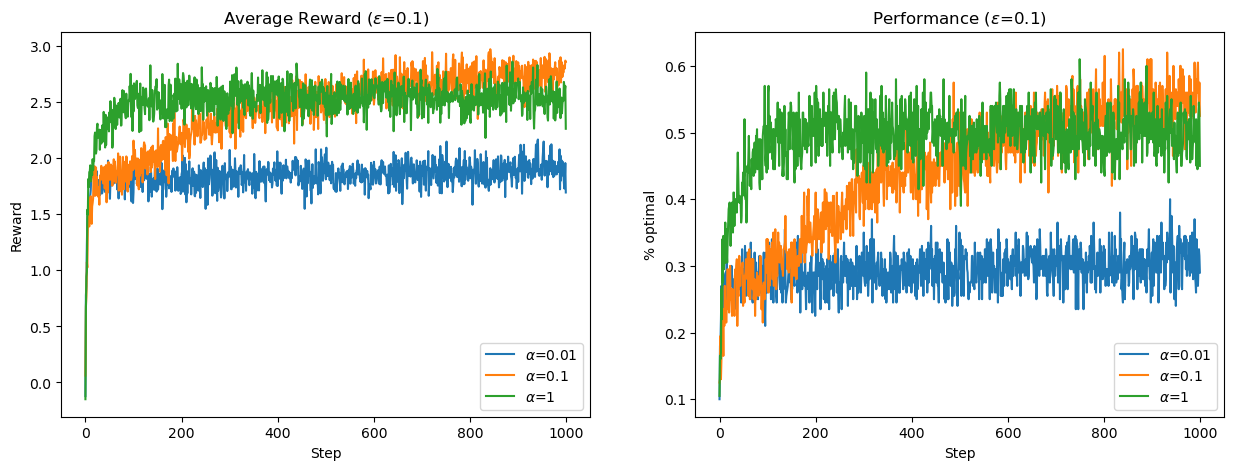

In [50]:
# set for reproducibility, change seed value for different results
np.random.seed(5)

# let's keep epsilon fixed but vary the learning rate:
epsilon = 0.1
alphas = [0.01, 0.1, 1.0]

n_trials = 200

trial_rewards = np.zeros((len(alphas), n_trials, n_steps))
trial_optimal = np.zeros((len(alphas), n_trials, n_steps))

for i, alpha in enumerate(alphas):
  for n in range(n_trials):
    results = multi_armed_bandit(n_arms, n_steps, epsilon, alpha)
    trial_rewards[i, n] = results['rewards']
    trial_optimal[i, n] = results['optimal']

labels = ['$\\alpha$=0.01','$\\alpha$=0.1','$\\alpha$=1']
fixed = '$\epsilon$=0.1'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)

In [30]:
# @title Exercise 2.1: Understanding the algorithm

What do the above plots mean?

In [31]:
# @title Exercise 2.2: Role of parameters in epsilon greedy

What do you observe? Can you **break** learning under different parameter settings? 

Think about how you could modify the code above to account for **different task settings**. A popular approach, for example, is to induce '**reversals**' or simple changes of the reward contengies from time to time, to study learning in a changing environment. How could you incorporate such changes in the multi armed bandit agent above?

## Define Multi-Armed Bandits with different action selection rules

In [32]:
# @title Exercise 2.3: Compare different models of action selection

Now we've implemented the basics of a multi-armed bandit agent as well as assessing its performance.

Let's move on to the main question if this tutorial: **compare the performance of the different agents**.

Take some time to implement a multi-armed bandit agent under the different action selection rules above. Doing this right takes some time and you will find a suggestion below. However, do take some time to try this yourself.

You can either copy the definition of the multi-armed bandit agent above and change the action selection rule in the definition, then simulate its performance. You could also write a new multi-armed bandit function below that implements the different action selection rules (this is a bit more work though and you can find an example below).

What performance differences do you observe, and how are they in line with your expectations?

In [33]:
# @title Full Solution multi_armed_bandit_DiffActions

def multi_armed_bandit_DiffActions(n_arms, n_steps, epsilon=0.15, alpha=0.01, beta=2, c=5):

  """ A Gaussian multi-armed bandit using an epsilon-greedy policy. For each
  action, rewards are randomly sampled from normal distribution, with a mean
  associated with that arm and unit variance.
  
  Args:
    n_arms: number of arms or actions
    epsilon: probability of selecting an action randomly
    alpha: the learning rate
    n_steps: number of steps to evaluate
  
  Returns:
    dict: a dictionary containing the action values, actions, and rewards from
    the evaluation along with the true arm parameters mu and the optimality of
    the chosen actions.
  """
  # Gaussian bandit parameters  
  mu = np.random.normal(scale=2,size=n_arms)

  ##### evaluation and reporting state for different action selection rules #####
  v_greedy     = np.zeros(n_arms)  
  vs_greedy    = np.zeros((n_steps, n_arms))
  
  v_epsgreedy  = np.zeros(n_arms)  
  vs_epsgreedy = np.zeros((n_steps, n_arms))

  v_softmax    = np.zeros(n_arms)  
  vs_softmax   = np.zeros((n_steps, n_arms))

  v_UCB        = np.zeros(n_arms)  
  vs_UCB       = np.zeros((n_steps, n_arms))

  # for the UCB
  N = np.ones(n_arms)

  ##### Define variables under the different action selection rules #####
  rewards_greedy    = np.zeros(n_steps)
  rewards_epsgreedy = np.zeros(n_steps)
  rewards_softmax   = np.zeros(n_steps)
  rewards_UCB       = np.zeros(n_steps)

  actions_greedy    = np.zeros(n_steps)
  actions_epsgreedy = np.zeros(n_steps)
  actions_softmax   = np.zeros(n_steps)
  actions_UCB       = np.zeros(n_steps)

  optimal_greedy    = np.zeros(n_steps)
  optimal_epsgreedy = np.zeros(n_steps)
  optimal_softmax   = np.zeros(n_steps)
  optimal_UCB       = np.zeros(n_steps)

  # run the bandit
  for t in range(n_steps):
    ##### Different types of action selection #####
    # choose an action based on a greedy policy
    action_greedy = greedy(v_greedy)
    actions_greedy[t] = action_greedy

    # choose an action based on an epsilon-greedy policy
    action_epsgreedy = epsilon_greedy(v_epsgreedy,epsilon)
    actions_epsgreedy[t] = action_epsgreedy

    # choose an action based on a softmax policy
    action_softmax = softmax_rule(v_softmax,beta) 
    actions_softmax[t] = action_softmax

    # choose an action based on an upper confidence bound policy
    action_UCB = upp_conf_bound(v_UCB,c=c,t=t+1,N=N) 
    actions_UCB[t] = action_UCB
    N[action_UCB] += 1
    
    # compute rewards for all possible actions
    all_rewards = np.random.normal(mu)

    ##### Observe rewards for the chosen action under different action selection #####
    # greedy policy
    reward_greedy = all_rewards[action_greedy]    
    rewards_greedy[t] = reward_greedy

    # epsilon-greedy policy
    reward_epsgreedy = all_rewards[action_epsgreedy]    
    rewards_epsgreedy[t] = reward_epsgreedy

    # softmax policy
    reward_softmax = all_rewards[action_softmax]    
    rewards_softmax[t] = reward_softmax

    # upper confidence bound policy
    reward_UCB = all_rewards[action_UCB]    
    rewards_UCB[t] = reward_UCB

    # was it the best possible choice?
    optimal_action = np.argmax(all_rewards)

    ##### find if selected action under different action selection rules was optimal #####
    # greedy policy
    optimal_greedy[t]    = action_greedy == optimal_action
    # epsilon-greedy policy
    optimal_epsgreedy[t] = action_epsgreedy == optimal_action
    # softmax policy
    optimal_softmax[t]   = action_softmax == optimal_action
    # upper confidence bound policy
    optimal_UCB[t]       = action_UCB == optimal_action

    ##### Update the action values under different action selection rules #####
    # greedy policy
    v_greedy[action_greedy] = update_action_value(v_greedy, action_greedy, reward_greedy, alpha)
    vs_greedy[t] = v_greedy
    # epsilon-greedy policy
    v_epsgreedy[action_epsgreedy] = update_action_value(v_epsgreedy, action_epsgreedy, reward_epsgreedy, alpha)
    vs_epsgreedy[t] = v_epsgreedy
    # softmax policy
    v_softmax[action_softmax] = update_action_value(v_softmax, action_softmax, reward_softmax, alpha)
    vs_softmax[t] = v_softmax
    # upper confidence bound policy
    v_UCB[action_UCB] = update_action_value(v_UCB, action_UCB, reward_UCB, alpha)
    vs_UCB[t] = v_UCB

  results = {
      # greedy policy
      'vs_greedy': vs_greedy,
      'actions_greedy': actions_greedy,
      'rewards_greedy': rewards_greedy,
      'optimal_greedy': optimal_greedy,
      # epsilon-greedy policy
      'vs_epsgreedy': vs_epsgreedy,
      'actions_epsgreedy': actions_epsgreedy,
      'rewards_epsgreedy': rewards_epsgreedy,
      'optimal_epsgreedy': optimal_epsgreedy,
      # softmax policy
      'vs_softmax': vs_softmax,
      'actions_softmax': actions_softmax,
      'rewards_softmax': rewards_softmax,
      'optimal_softmax': optimal_softmax,
      # upper confidence bound policy
      'vs_UCB': vs_UCB,
      'actions_UCB': actions_UCB,
      'rewards_UCB': rewards_UCB,
      'optimal_UCB': optimal_UCB,
      'mu': mu
  }
  
  return results

Output should look like this:
Greedy Action Selection


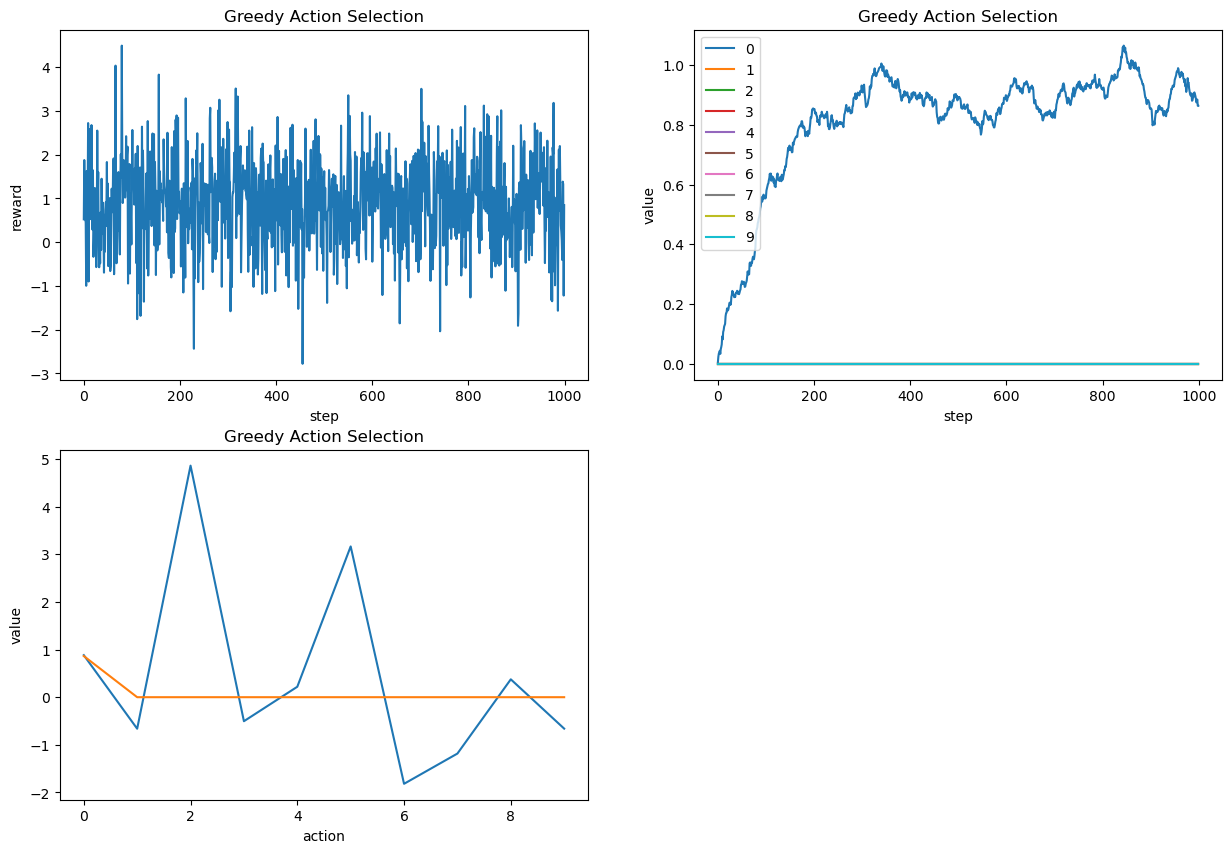

Epsilon-Greedy Action Selection


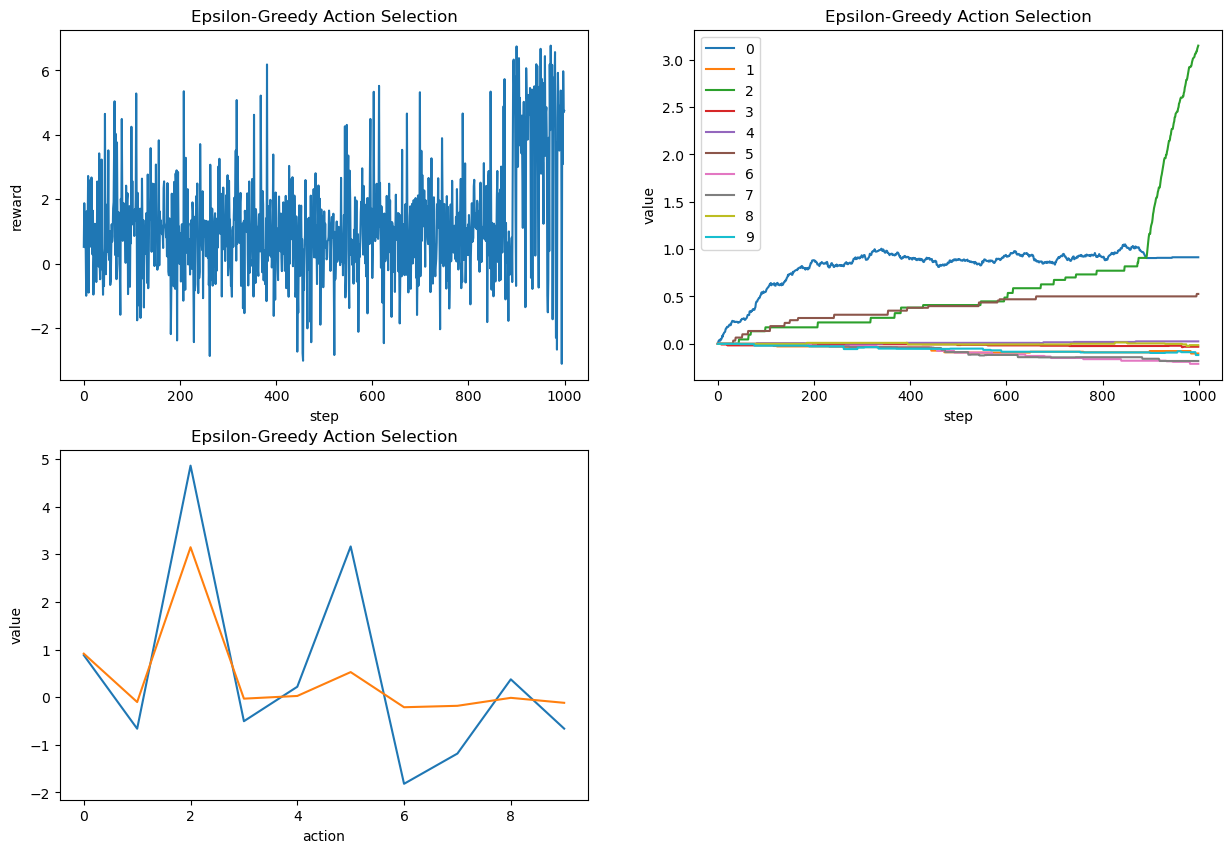

Softmax Action Selection


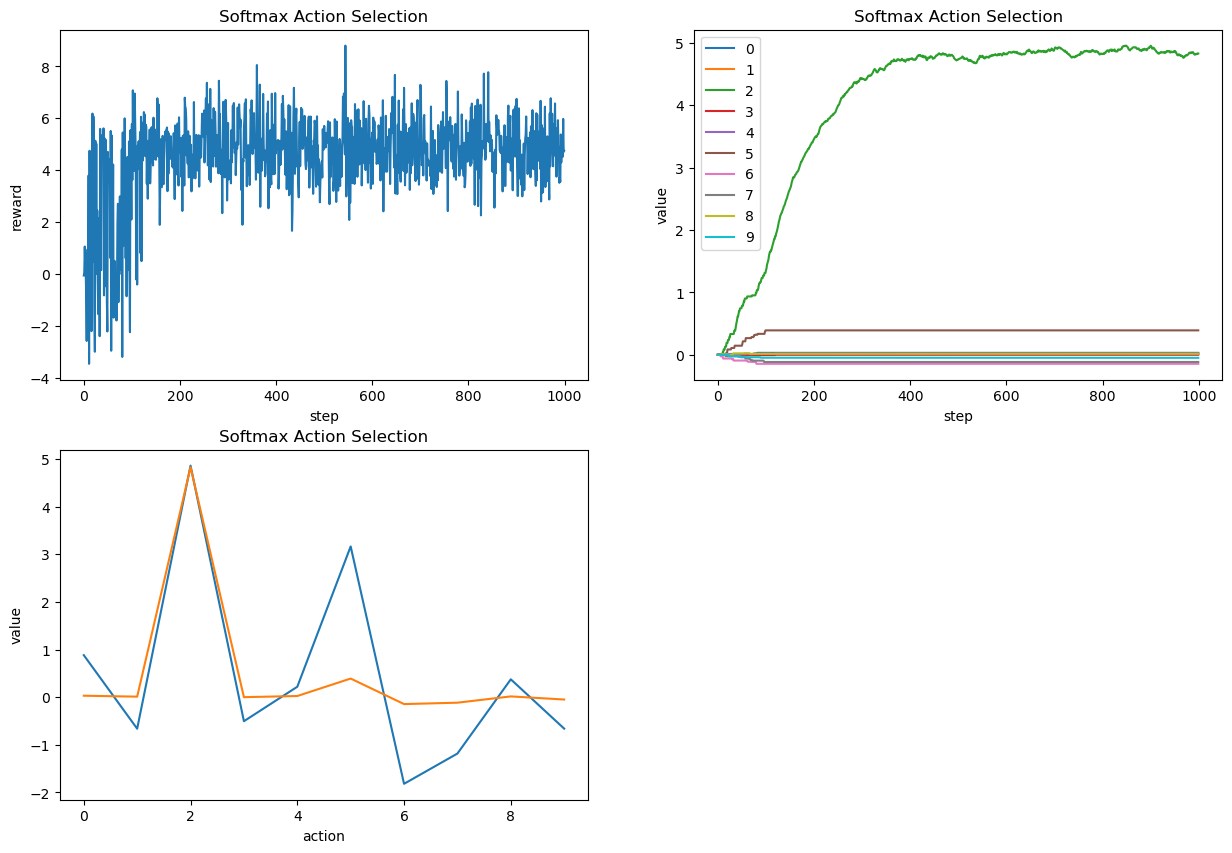

Upper-Confidence-Bound Action Selection


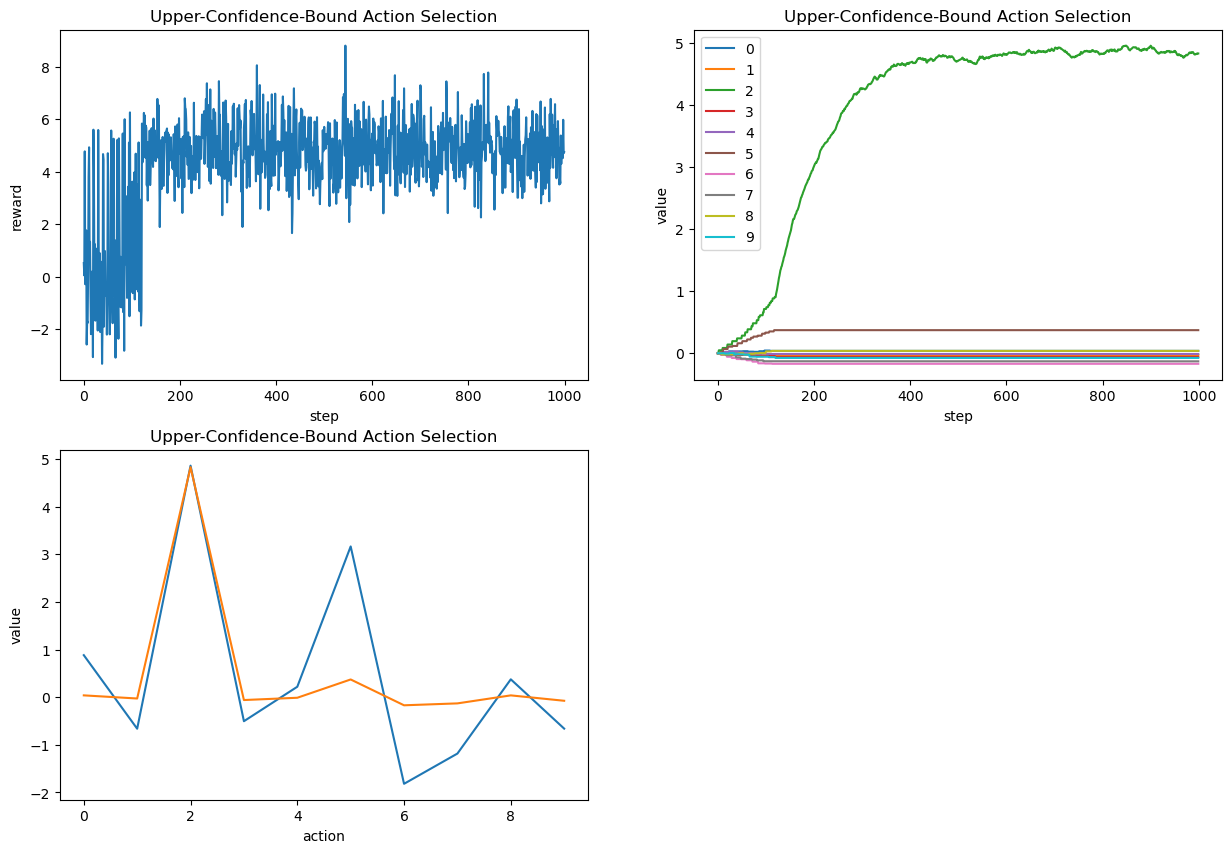

In [34]:
# @title Full Solution test and compare learning

print("Output should look like this:")

# set for reproducibility, change seed value for different results
np.random.seed(5)

n_arms  = 10
n_steps = 1000

types_ActionSelection  = ["greedy","epsgreedy","softmax","UCB"]
titles_ActionSelection = ["Greedy Action Selection","Epsilon-Greedy Action Selection",
                          "Softmax Action Selection","Upper-Confidence-Bound Action Selection"]

results = multi_armed_bandit_DiffActions(n_arms, n_steps)

for idx_plot in np.arange(len(types_ActionSelection)):

  print(titles_ActionSelection[idx_plot])

  plt.rcParams['figure.figsize'] = [15, 10]
  rows = 2
  cols = 2
  fig = plt.figure() 
  fig_count = 1;

  fig.add_subplot(rows, cols, fig_count)
  plt.plot(results['rewards_' + types_ActionSelection[idx_plot]])
  plt.ylabel('reward')
  plt.xlabel('step')
  plt.title(titles_ActionSelection[idx_plot])
  fig_count += 1;

  fig.add_subplot(rows, cols, fig_count)
  plt.plot(results['vs_' + types_ActionSelection[idx_plot]])
  plt.ylabel('value')
  plt.xlabel('step')
  plt.title(titles_ActionSelection[idx_plot])
  plt.legend(np.arange(n_arms))
  fig_count += 1;

  fig.add_subplot(rows, cols, fig_count)
  plt.plot(results['mu'], label='latent')
  plt.plot(results['vs_' + types_ActionSelection[idx_plot]][-1], label='learned')
  plt.ylabel('value')
  plt.xlabel('action')
  plt.title(titles_ActionSelection[idx_plot])
  fig_count += 1;

  plt.show()

greedy. 没学会2是最优选。一直选0，也只根据0的reward学到0的value。其他选项的value没有converge。

epsilon-greedy. 在900步的时候2的value开始超过1(可能探索到了2更好，开始更多选2)。部分选项converges.

softmax. 一开始就根据value来确定每个选项的被选择的概率。一开始就学到2最好，部分选项converge.

ucb. 根据value和选择历史来确定之后的被选概率，没选过的多探索。一开始就学到2最好。相比与softmax，一开始对其他选项的探索更多一些，拿到的reward波动也就大一些。【tw. 留给自己一些uncertainty buffer去探索其他选项，reward或许会更好】


Output should look like this:


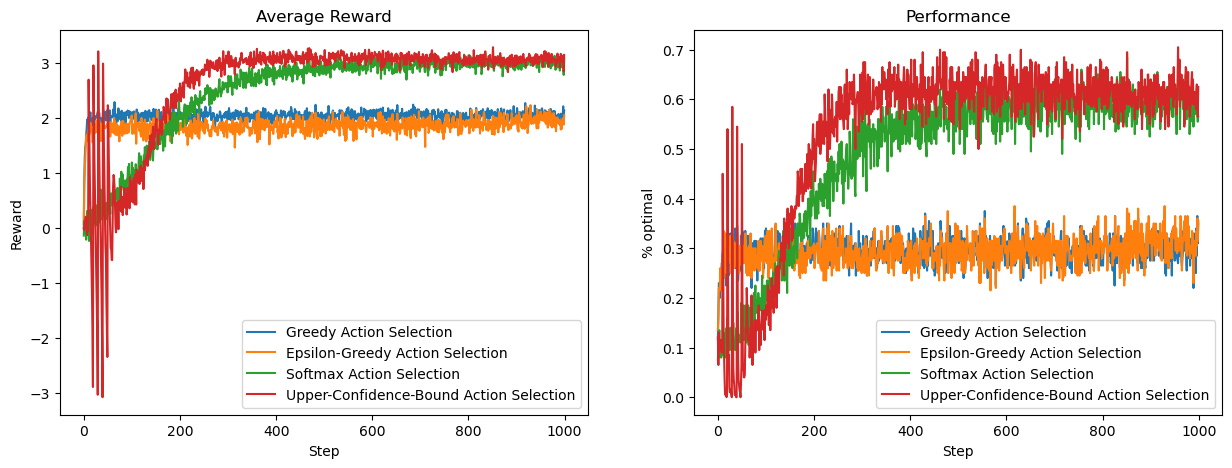

In [35]:
# @title Full Solution test and compare performance

print("Output should look like this:")

# set for reproducibility, comment out / change seed value for different results
np.random.seed(5)

n_arms  = 10
n_steps = 1000

n_trials = 200
# n_trials = 50

types_ActionSelection  = ["greedy","epsgreedy","softmax","UCB"]
titles_ActionSelection = ["Greedy Action Selection","Epsilon-Greedy Action Selection",
                          "Softmax Action Selection","Upper-Confidence-Bound Action Selection"]

trial_rewards = np.zeros((len(types_ActionSelection), n_trials, n_steps))
trial_optimal = np.zeros((len(types_ActionSelection), n_trials, n_steps))

means_test = []

for n in range(n_trials):

  results = multi_armed_bandit_DiffActions(n_arms, n_steps)

  trial_rewards[0, n, :] = results['rewards_' + types_ActionSelection[0]]
  trial_rewards[1, n, :] = results['rewards_' + types_ActionSelection[1]]
  trial_rewards[2, n, :] = results['rewards_' + types_ActionSelection[2]]
  trial_rewards[3, n, :] = results['rewards_' + types_ActionSelection[3]]

  means_test.append(np.mean(results['rewards_' + types_ActionSelection[0]]))

  trial_optimal[0, n, :] = results['optimal_' + types_ActionSelection[0]]
  trial_optimal[1, n, :] = results['optimal_' + types_ActionSelection[1]]
  trial_optimal[2, n, :] = results['optimal_' + types_ActionSelection[2]]
  trial_optimal[3, n, :] = results['optimal_' + types_ActionSelection[3]]

labels = titles_ActionSelection
fixed = []
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)

In [36]:
# @title Exercise 2.4: Performance differences

There are a lot of interesting things to observe - and changes to make in the parameter setting! A few general ones are:

* Why is the performance of greedy and epsilon-greedy so similar in this specific example (check carefully when epsilon-greedy seems to become smarter than just greedy in these specific simulations)? Can you still spot some differences?

可能因为epsilon太小，没有充分探索其他选项。

* Why is the performance of the greedy policy not always zero? (Hint: this has to do with how the rewards are sampled in every trial)

一直选0，得到的是选项0的reward的平均值。

* There is an interesting trade-off in the beta parameter for the softmax about learning the structure of the task and optimising for reward. Can you see what that is?

beta高，对value更敏感，大的value被选的可能高得多，同时对其他选项的探索就少了。如果一开始选在次优的，学习中value趋向于reward，也在增加，不太容易跳出来。选不到最优的。

* Why is the UCB in the beginning so noisy? What parameter/s governs that degree of noise?

value还没学到位，还在探索，每一个都在选。无法对value大且选得多的惩罚。